# Demo: Mean-Variance Portfolio Investment Backtesting


## Reference:
- 量化投资分析工具quantstats介绍及其在backtrader量化框架中使用.https://zhuanlan.zhihu.com/p/507760842
- Mean-variance optimization.https://pyportfolioopt.readthedocs.io/en/latest/UserGuide.html#processing-historical-prices

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context="talk", style="whitegrid", palette="colorblind", color_codes=True,  rc={"figure.figsize": [16, 8]})

In [97]:
#import the libraries
!pip install yfinance
!pip install PyPortfolioOpt
!pip install backtrader
!pip install quantstats
import pypfopt
import quantstats as qs
from datetime import datetime
import backtrader as bt
import pandas as pd
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [98]:
class MyBuySell(bt.observers.BuySell):
    '''
    Custom color and plot styles of the buy/sell indicators.
    '''
    plotlines = dict(buy=dict(marker="^", markersize=8.0, color="green", fillstyle="full"),
                     sell=dict(marker="v", markersize=8.0, color="red", fillstyle="full"))

def get_action_log_string(dir, action, price, size, asset=None, cost=None, commission=None, cash=None, open=None, close=None):
    '''
    Creates a string indicating a created/executed buy/sell order.
    Args:
        dir (str): The direction of the position, can be a value in ["b", "s"]
        action (str): The action, can be a value in ["e", "c"]
        price (float): The price
        size (float, optional): The size. Defaults to None.
        asset (str): name of the asset
        cost (float, optional): The cost.
        commission (float, optional): The comission. 
        cash (float, optional): The cash amount. 
        open (float, optional): The open price. 
        close (float, optional): The close price. 
    Returns:
        str: The string used for printing
    '''
    dir_dict = {'b': 'BUY',
                's': 'SELL'}
    action_dict = {'e': 'EXECUTED',
                   'c': 'CREATED'}
    str = (f'{dir_dict[dir]} {action_dict[action]} - '  f'Price: {price:.2f}, Size: {size:.2f}')

    if asset is not None:
        str = str + f', Asset: {asset}'
    if action =='e':
        if cost is not None:
            str = str + f', Cost: {cost:.2f}'
        if commission is not None:
            str = str + f', Commission: {commission:.2f}'
    elif action =='c':
        if cash is not None:
            str = str + f', Cash: {cash:.2f}'
        if open is not None:
            str = str + f', Open: {open:.2f}'
        if close is not None:
            str = str + f', Close: {close:.2f}'
    return str

def get_result_log_string(gross, net):
    '''
    Creates a string indicating the summary of an operation.
    Args:
        gross (float): the gross outcome
        net (float): the net outcome
    Returns:
        str: The string used for logging
    '''
    str = f'OPERATION RESULT - Gross: {gross:.2f}, Net: {net:.2f}'
    return str

In [99]:
import backtrader as bt

class FractionalTradesCommission(bt.CommissionInfo):
    def getsize(self, price, cash):
        """Returns the fractional size"""
        return self.p.leverage * (cash / price)

2. Define the strategy:

In [100]:
class MeanVariancePortfolioInvestmentStrategy(bt.Strategy):
    params = (("n_periods", 252), )

    def __init__(self):  
        self.day_counter = 0 #for tracking the number of day, initialize here
               
    def log(self, txt):
        dt = self.datas[0].datetime.date(0).isoformat() #format the datetime
        print(f"{dt}: {txt}")

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]: #no action is required
            return

        # report executed order
        if order.status in [order.Completed]:
            direction = "b" if order.isbuy() else "s"
            log_str = get_action_log_string(asset=order.data._name,
                                            dir=direction, 
                                            action="e", 
                                            price=order.executed.price,
                                            size=order.executed.size,
                                            cost=order.executed.value, 
                                            commission=order.executed.comm)
            self.log(log_str)

        # report failed order
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log(f"Order Failed: {order.data._name}")
        # reset order to no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        self.log(get_result_log_string(gross=trade.pnl, net=trade.pnlcomm))

    def next(self):
        self.day_counter += 1. #check if we have enough data points
        if self.day_counter < self.p.n_periods:
            return
            
        # check if the date is a Friday
        today = self.datas[0].datetime.date()
        if today.weekday() != 4: 
            return

        # find and print the current allocation weights and components
        current_portfolio = {}
        for data in self.datas:
            current_portfolio[data._name] = (self.positions[data].size * data.close[0])
        portf_df = pd.DataFrame(current_portfolio, index=[0])
        print(f"Current allocation as of {today}")
        print(portf_df / portf_df.sum(axis=1).squeeze())

        # extract the past price data for each stock
        price_dict = {}
        for data in self.datas:
            price_dict[data._name] = data.close.get(0, self.p.n_periods+1)
        prices_df = pd.DataFrame(price_dict)

        # find the daily optimal portfolio weights with max sharpe ratio
        mu = mean_historical_return(prices_df)
        S = CovarianceShrinkage(prices_df).ledoit_wolf()
        ef = EfficientFrontier(mu, S)
        weights = ef.max_sharpe(risk_free_rate=0)
        print(f"Optimal allocation identified on {today}")
        print(pd.DataFrame(ef.clean_weights(), index=[0]))

        # create orders
        for allocation in list(ef.clean_weights().items()):
            self.order_target_percent(data=allocation[0],target=allocation[1])
    
    #print the initial and final portfolio value
    def start(self):
        print(f"Initial Portfolio Value: {self.broker.get_value():.2f}")
    def stop(self):
        print(f"Final Portfolio Value: {self.broker.get_value():.2f}")

In [101]:
#download the bundle stocks we are interested
TICKERS = ["META", "AMZN", "AAPL", "NFLX", "GOOG", "AMZN", "TSLA"]
data_list = []
import yfinance as yf
import backtrader.feeds as btfeeds
for ticker in TICKERS:
    data=btfeeds.PandasData(dataname=yf.download(ticker,start='2017-01-01',end='2021-12-31',auto_adjust=True))
    data_list.append(data) #push into the blank list

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [102]:
cerebro = bt.Cerebro(stdstats = False)
cerebro.addstrategy(MeanVariancePortfolioInvestmentStrategy)
for ind, ticker in enumerate(TICKERS):
    cerebro.adddata(data_list[ind], name=ticker)
cerebro.broker.setcash(1000.0)
cerebro.broker.addcommissioninfo(FractionalTradesCommission(commission=0))
cerebro.addobserver(MyBuySell)
cerebro.addobserver(bt.observers.Value)
cerebro.addanalyzer(bt.analyzers.TimeReturn, _name="time_return")

In [103]:
backtest_result = cerebro.run()

Initial Portfolio Value: 1000.00
Current allocation as of 2018-01-05
   META  AMZN  AAPL  NFLX  GOOG  TSLA
0   NaN   NaN   NaN   NaN   NaN   NaN
Optimal allocation identified on 2018-01-05
      META    AMZN     AAPL     NFLX     GOOG     TSLA
0  0.37241  0.1809  0.35373  0.08312  0.00145  0.00838
2018-01-08: BUY EXECUTED - Price: 187.20, Size: 1.99, Asset: META, Cost: 373.11, Commission: 0.00
2018-01-08: BUY EXECUTED - Price: 61.80, Size: 2.94, Asset: AMZN, Cost: 181.91, Commission: 0.00
2018-01-08: BUY EXECUTED - Price: 41.38, Size: 8.52, Asset: AAPL, Cost: 352.42, Commission: 0.00
2018-01-08: BUY EXECUTED - Price: 210.02, Size: 0.40, Asset: NFLX, Cost: 83.13, Commission: 0.00
2018-01-08: BUY EXECUTED - Price: 55.11, Size: 0.03, Asset: GOOG, Cost: 1.45, Commission: 0.00
2018-01-08: Order Failed: TSLA
Current allocation as of 2018-01-12
       META     AMZN      AAPL      NFLX      GOOG  TSLA
0  0.358723  0.19275  0.359177  0.087868  0.001481   0.0
Optimal allocation identified on 201

In [104]:
#get the stratey return as DataFrame
returns_dict = backtest_result[0].analyzers.time_return.get_analysis()
returns_df = pd.DataFrame(list(returns_dict.items()), columns = ["date", "return"]).set_index("date")

<Axes: title={'center': 'Mean-Variance Portfolio Investment Stratefy Daily Return'}, xlabel='date'>

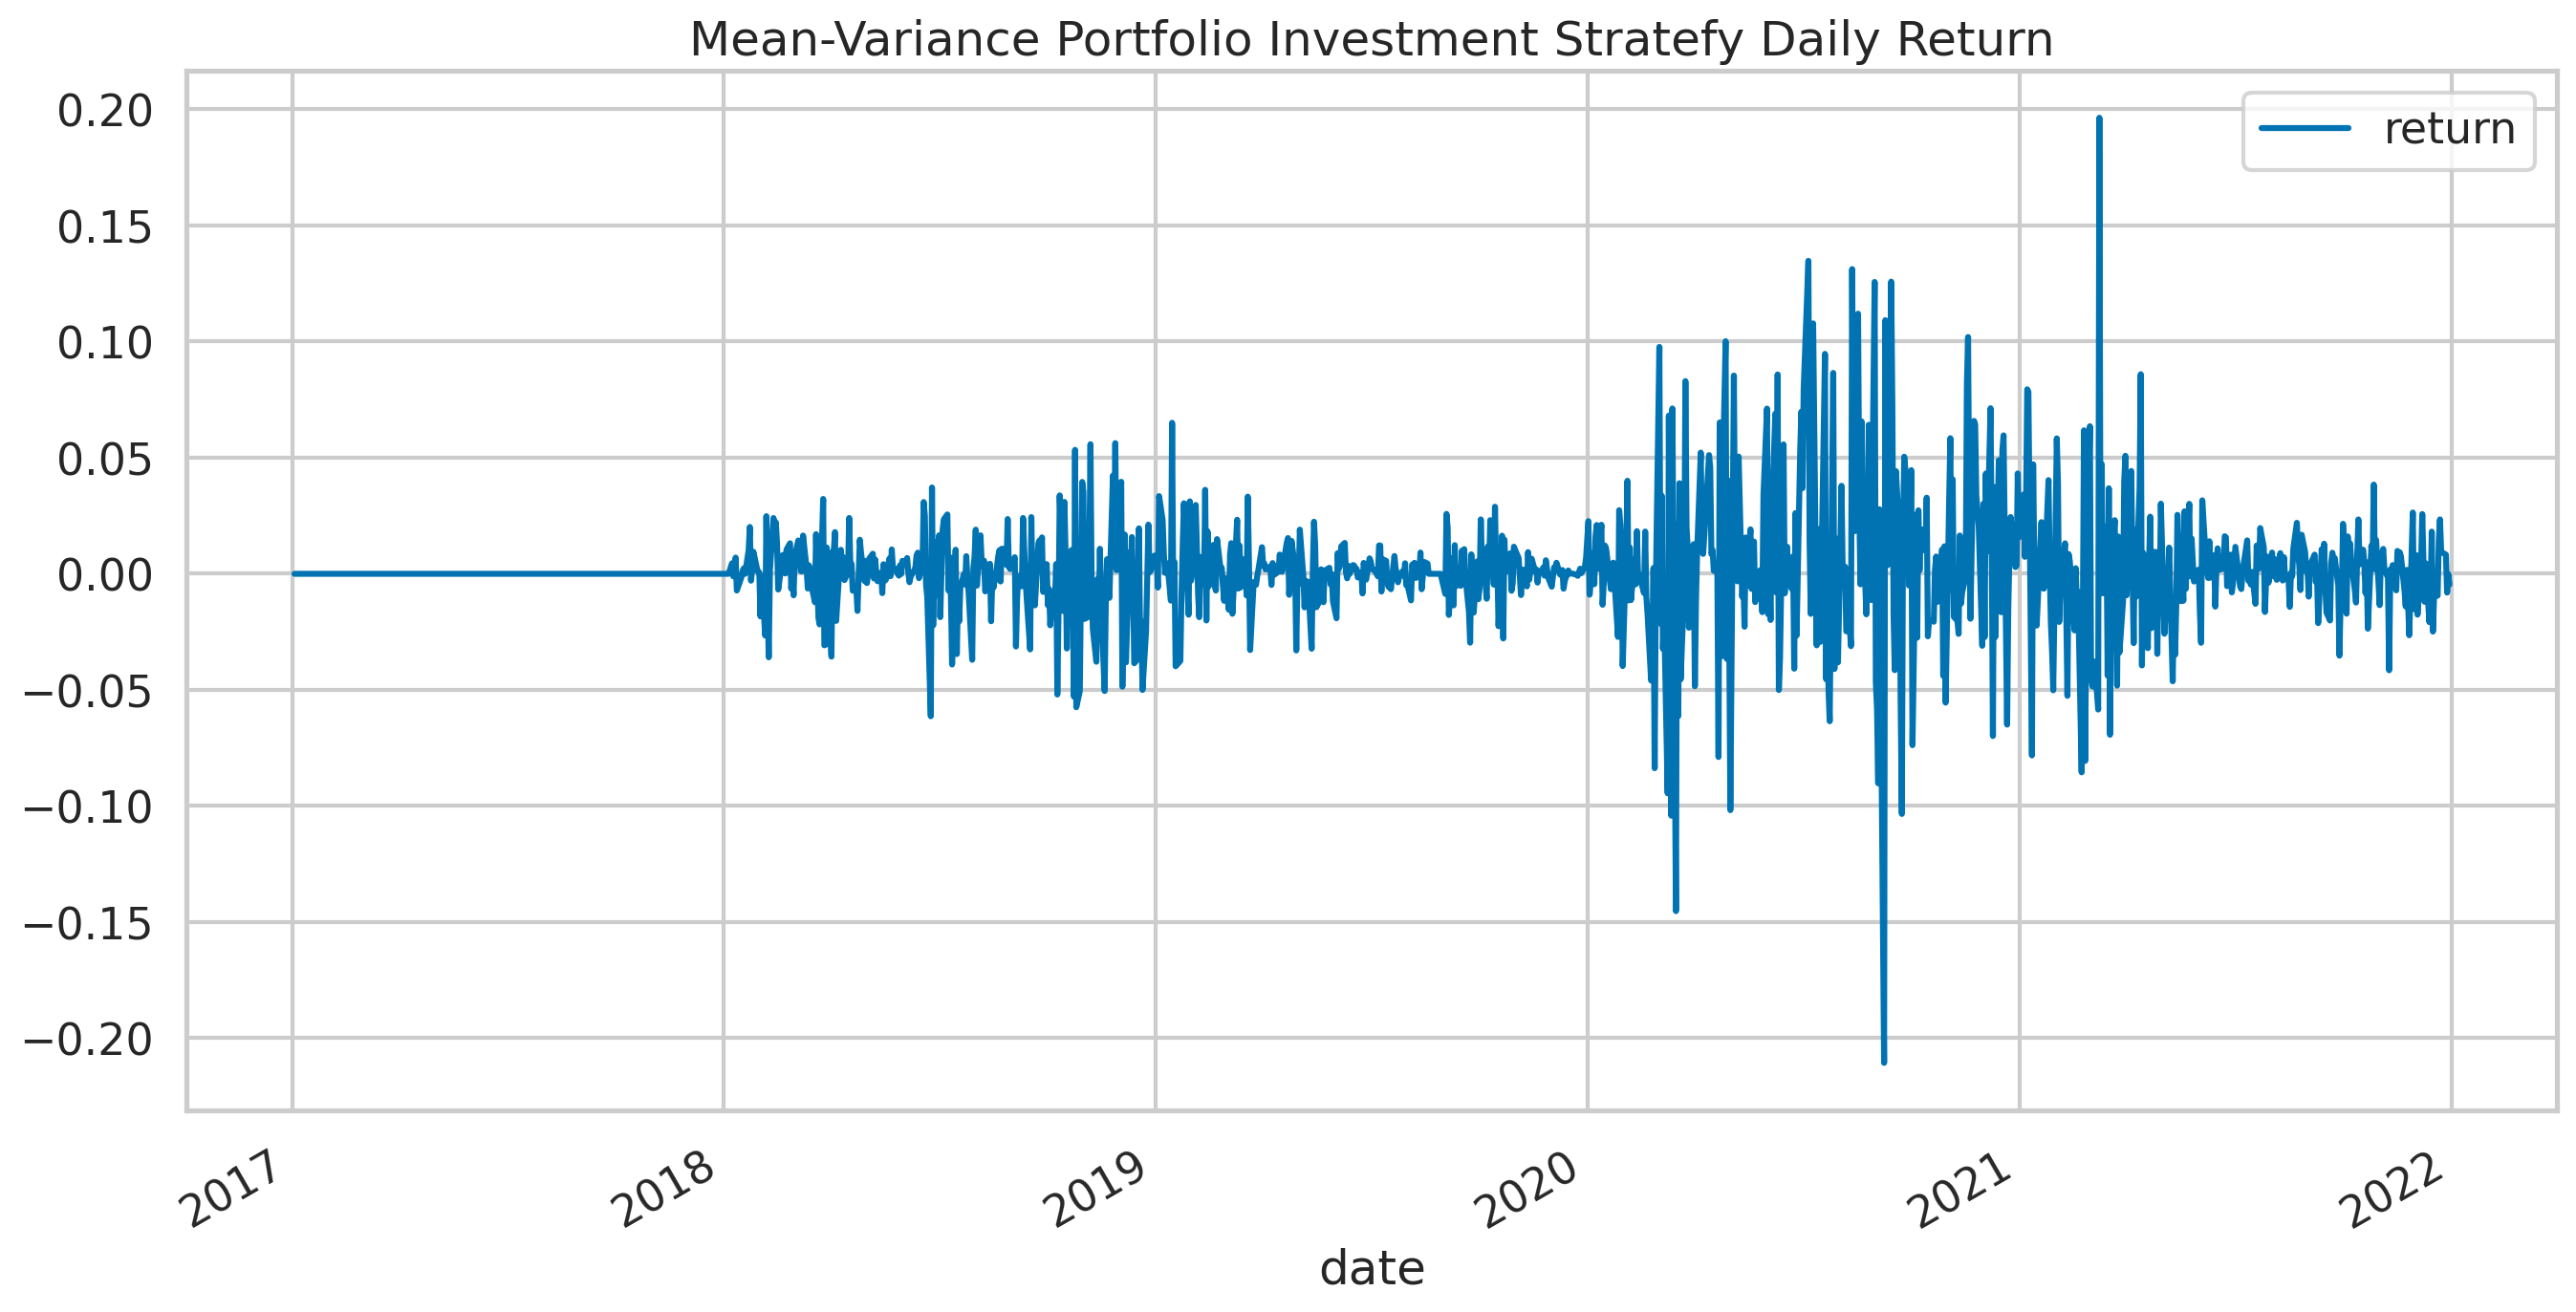

In [105]:
returns_df.plot(title="Mean-Variance Portfolio Investment Stratefy Daily Return")

In [106]:
#get the performance with S&P500 benchmark
Benchmark=pd.Series(yf.download("^GSPC", start='2018-01-01',end='2021-12-31')['Adj Close'].pct_change().dropna())

[*********************100%***********************]  1 of 1 completed


In [107]:
Benchmark.head()

Date
2018-01-03    0.006399
2018-01-04    0.004029
2018-01-05    0.007034
2018-01-08    0.001662
2018-01-09    0.001303
Name: Adj Close, dtype: float64

[Performance Metrics]



                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2018-01-05  2018-01-05
End Period                 2021-12-30  2021-12-30
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          391.05%     74.21%
CAGR﹪                     49.06%      14.94%

Sharpe                     1.1         0.76
Prob. Sharpe Ratio         98.64%      93.19%
Smart Sharpe               1.0         0.69
Sortino                    1.69        1.05
Smart Sortino              1.54        0.95
Sortino/√2                 1.2         0.74
Smart Sortino/√2           1.09        0.67
Omega                      1.25        1.25

Max Drawdown               -39.84%     -33.92%
Longest DD Days            701         214
Volatility (ann.)          45.74%      21.27%
R^2                        0.31        0.31
Information Ratio          0.06        0.06
Calmar                     1.23       

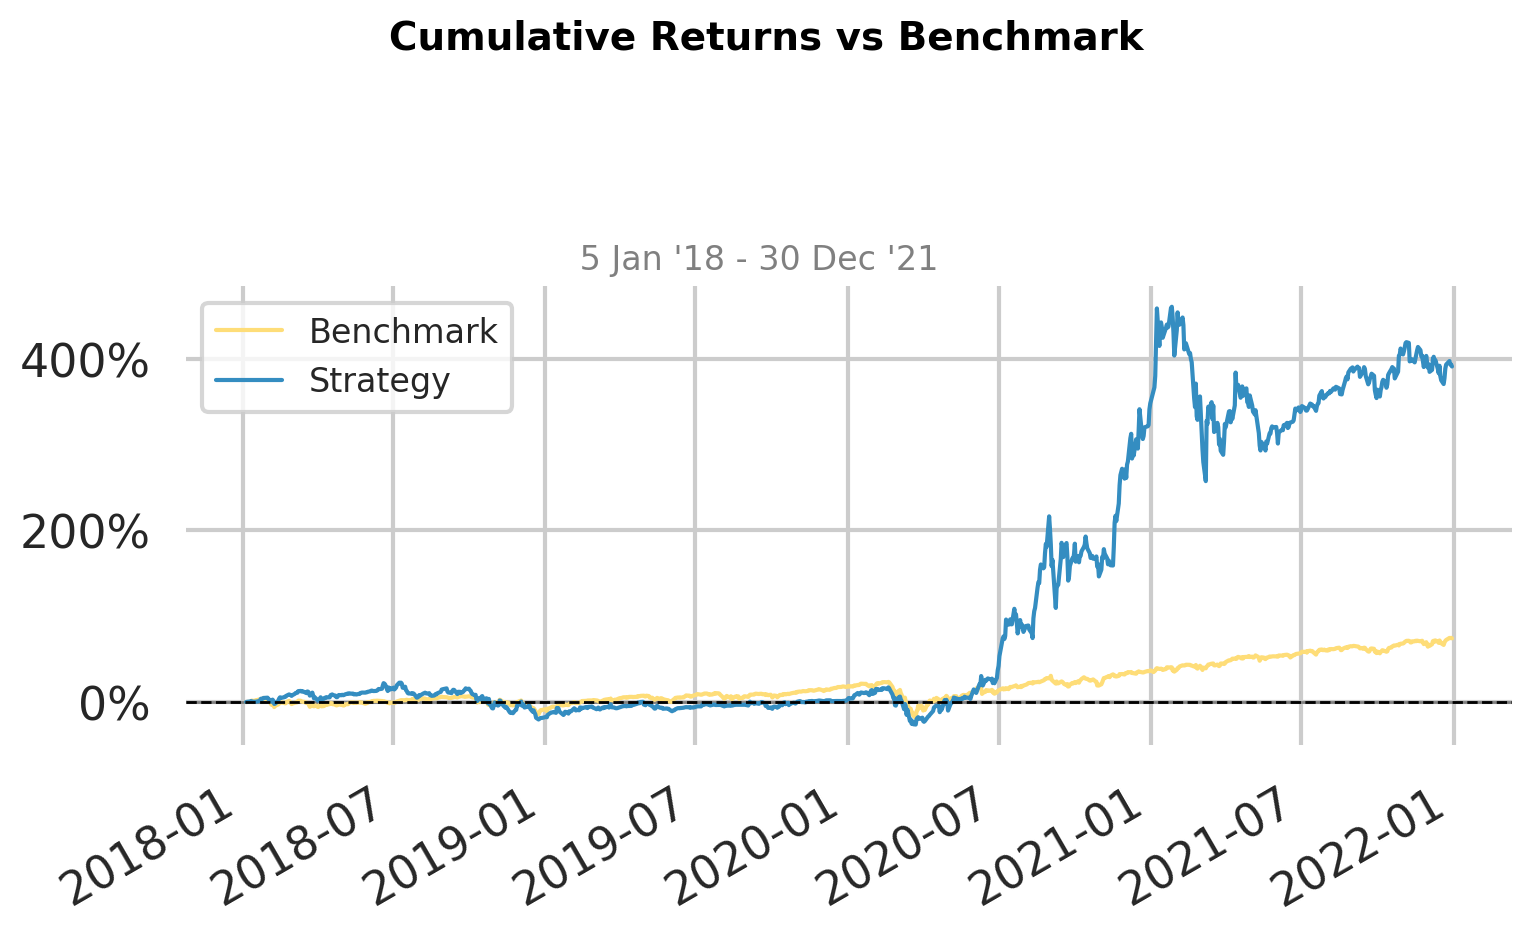

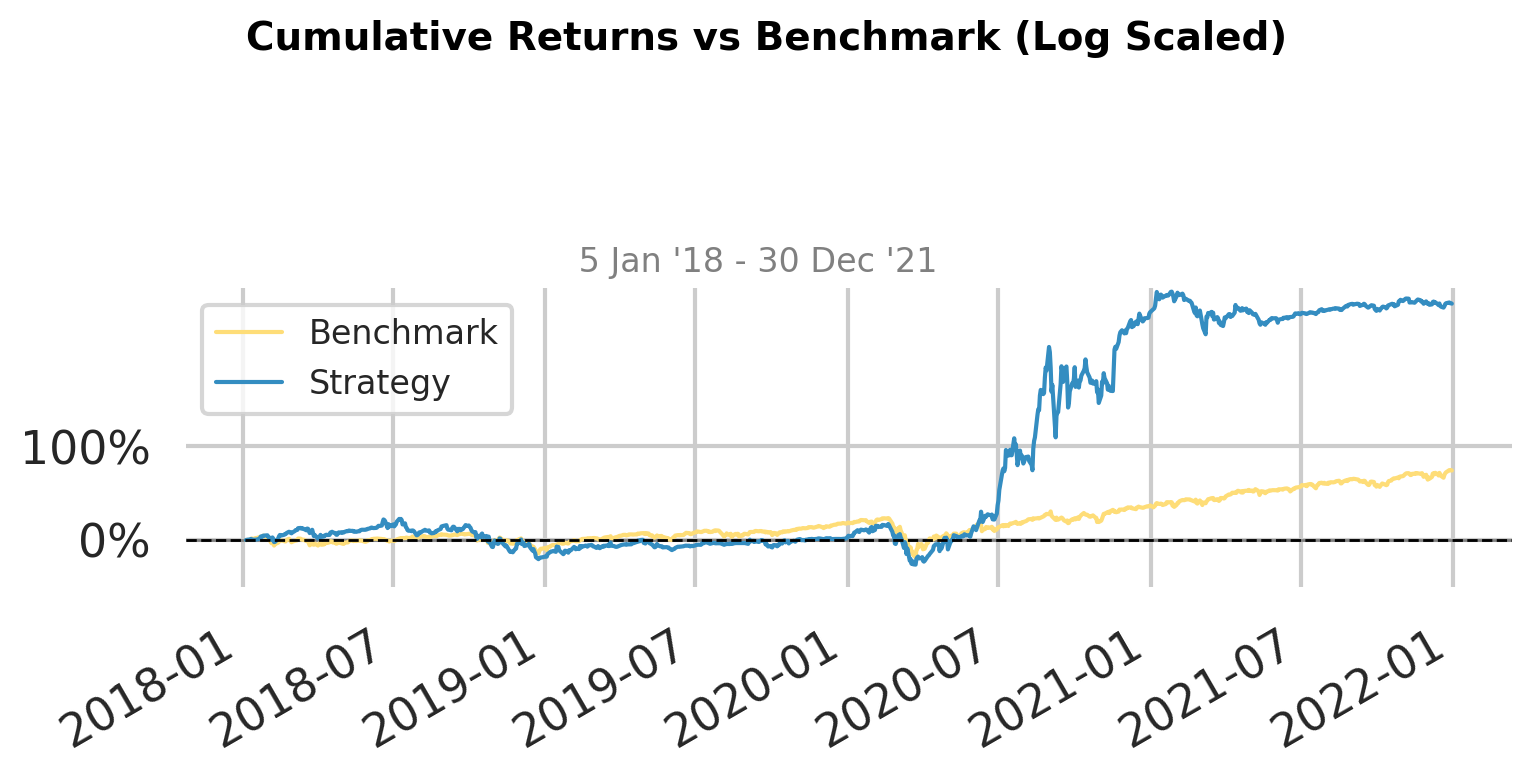

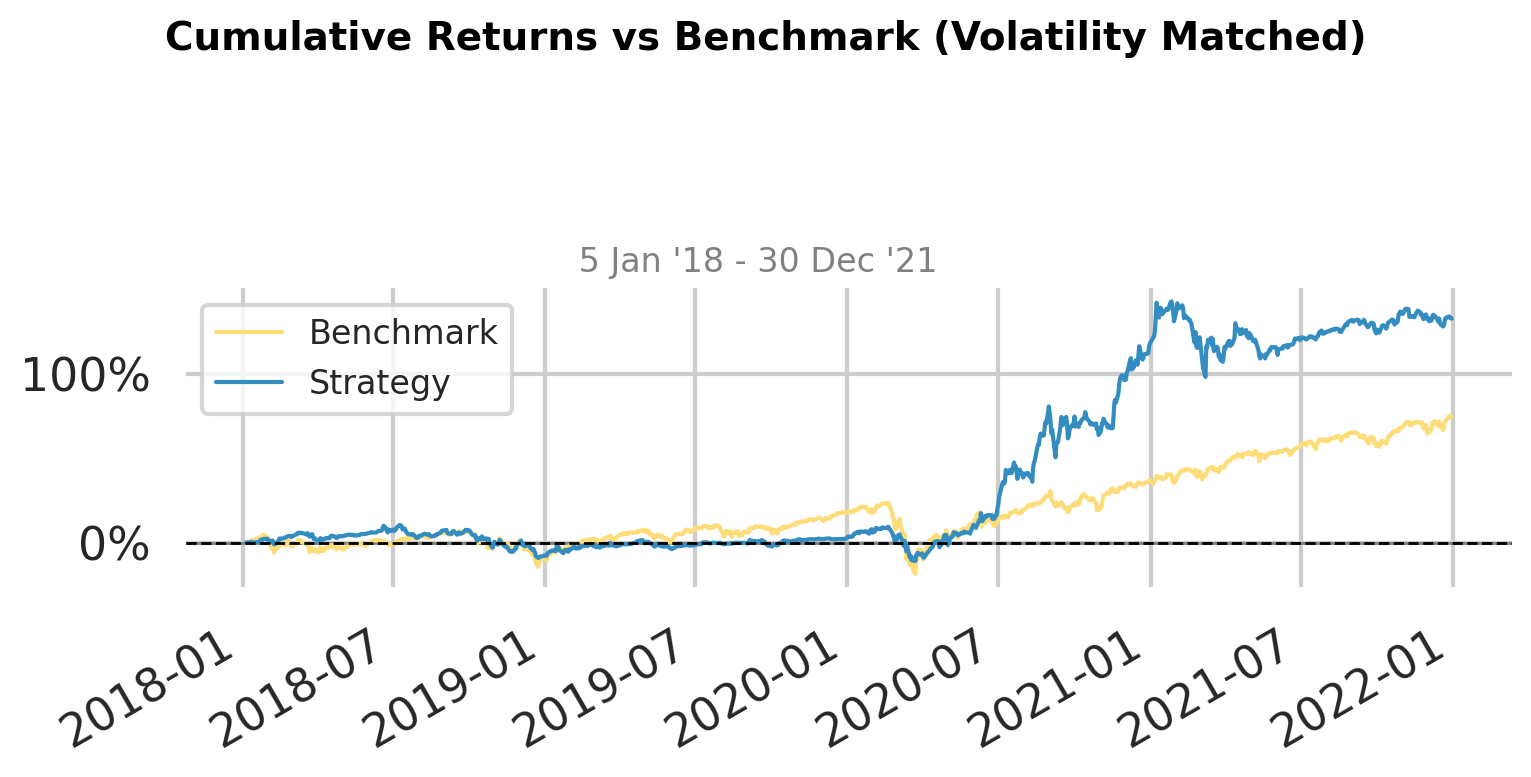

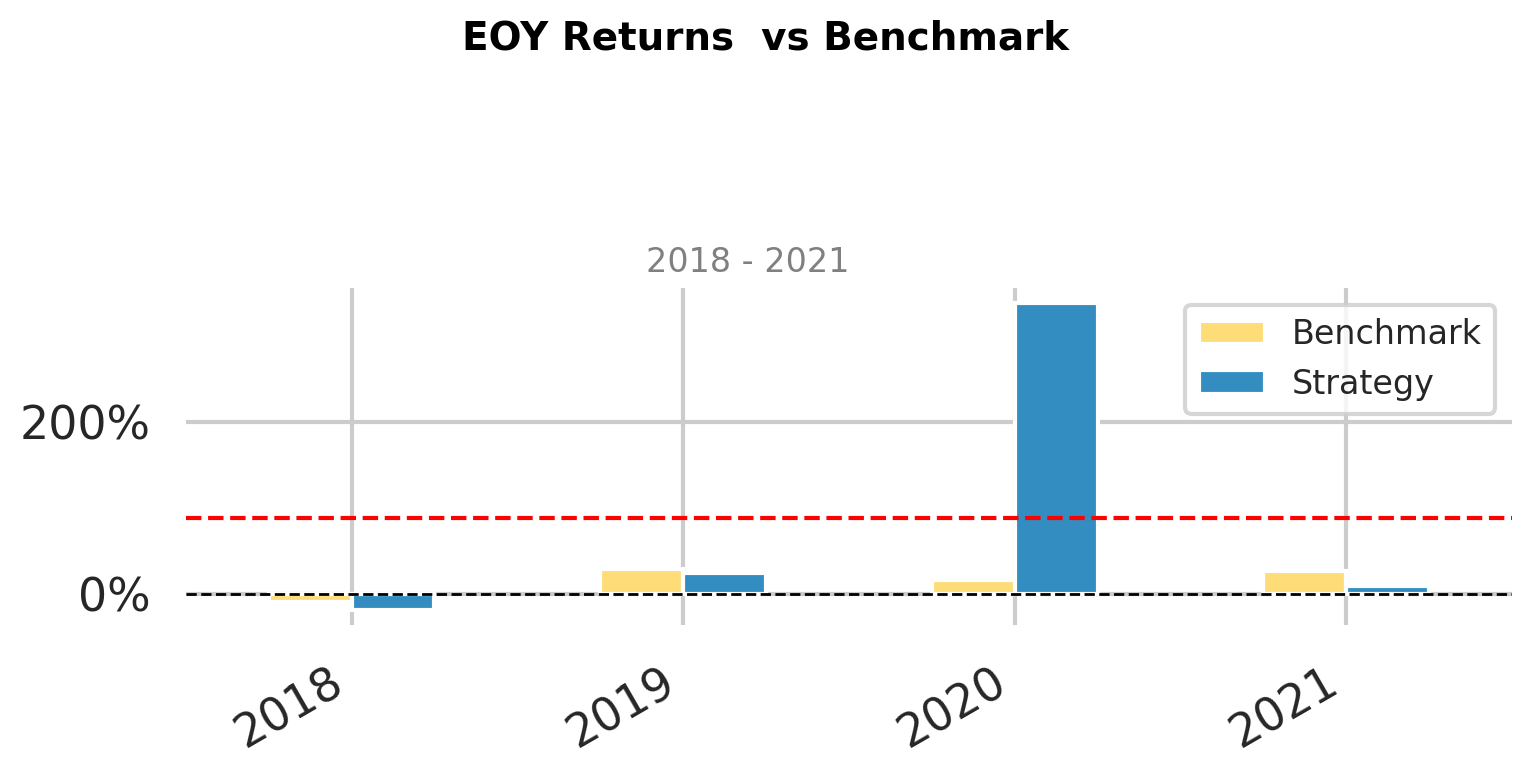

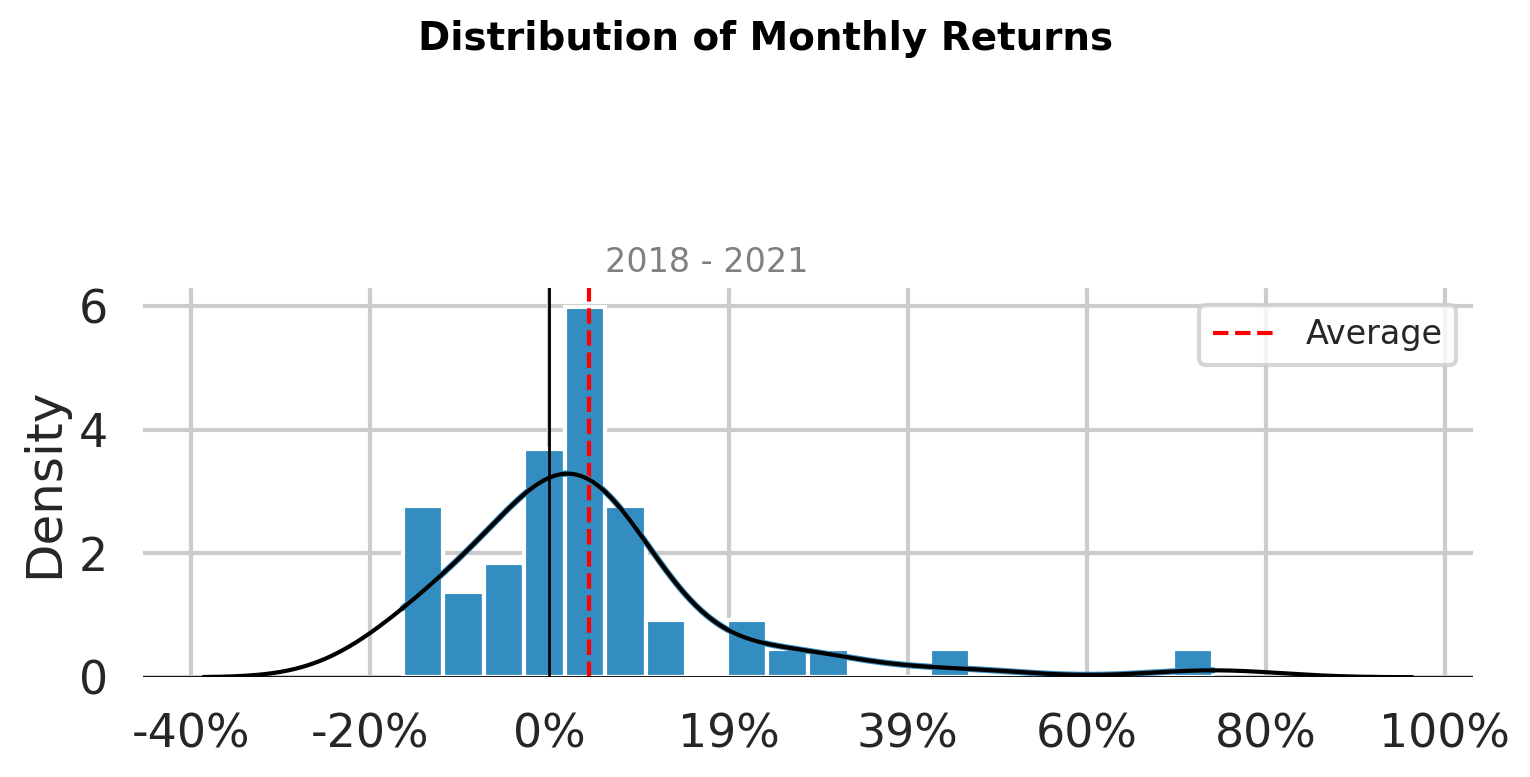

/usr/local/lib/python3.9/dist-packages/quantstats/_plotting/core.py:293: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


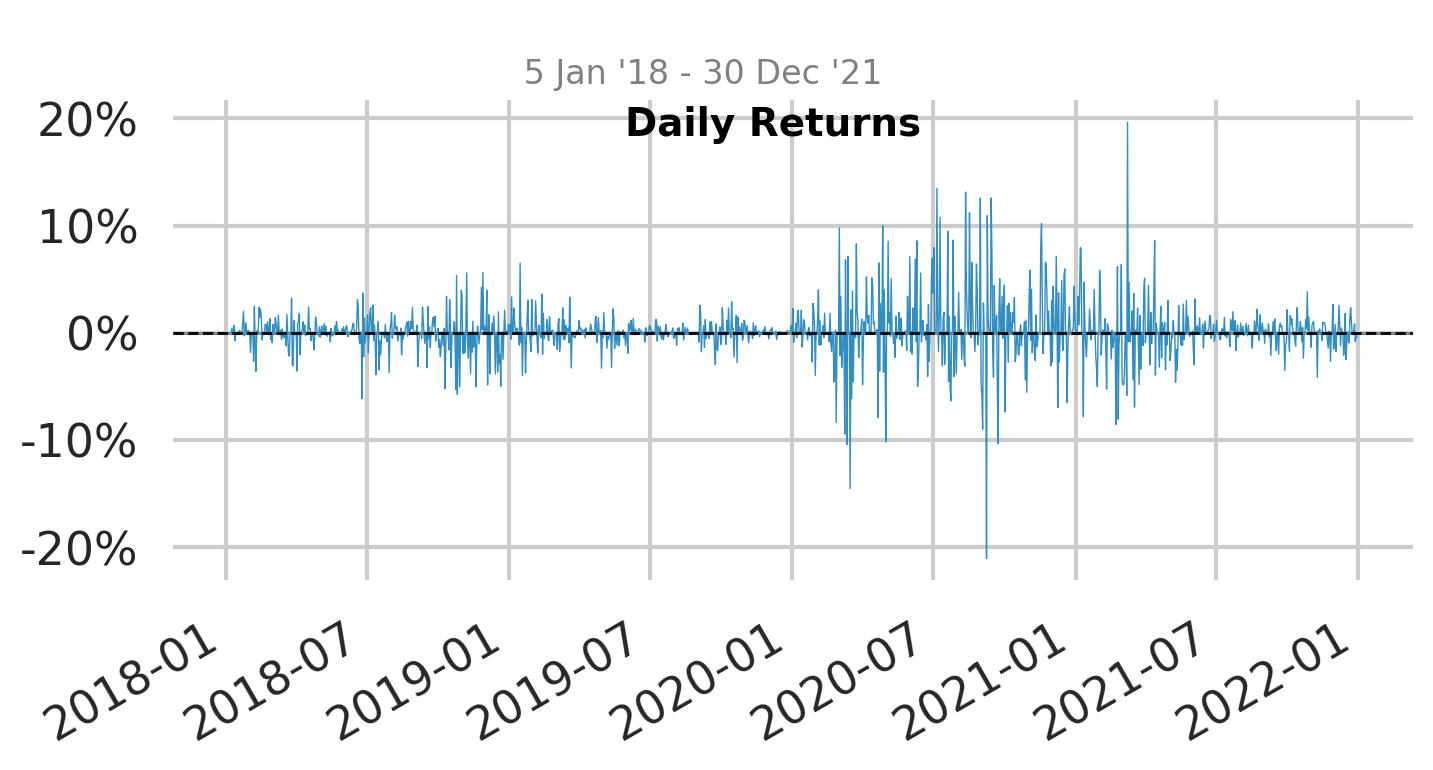

/usr/local/lib/python3.9/dist-packages/quantstats/_plotting/core.py:540: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


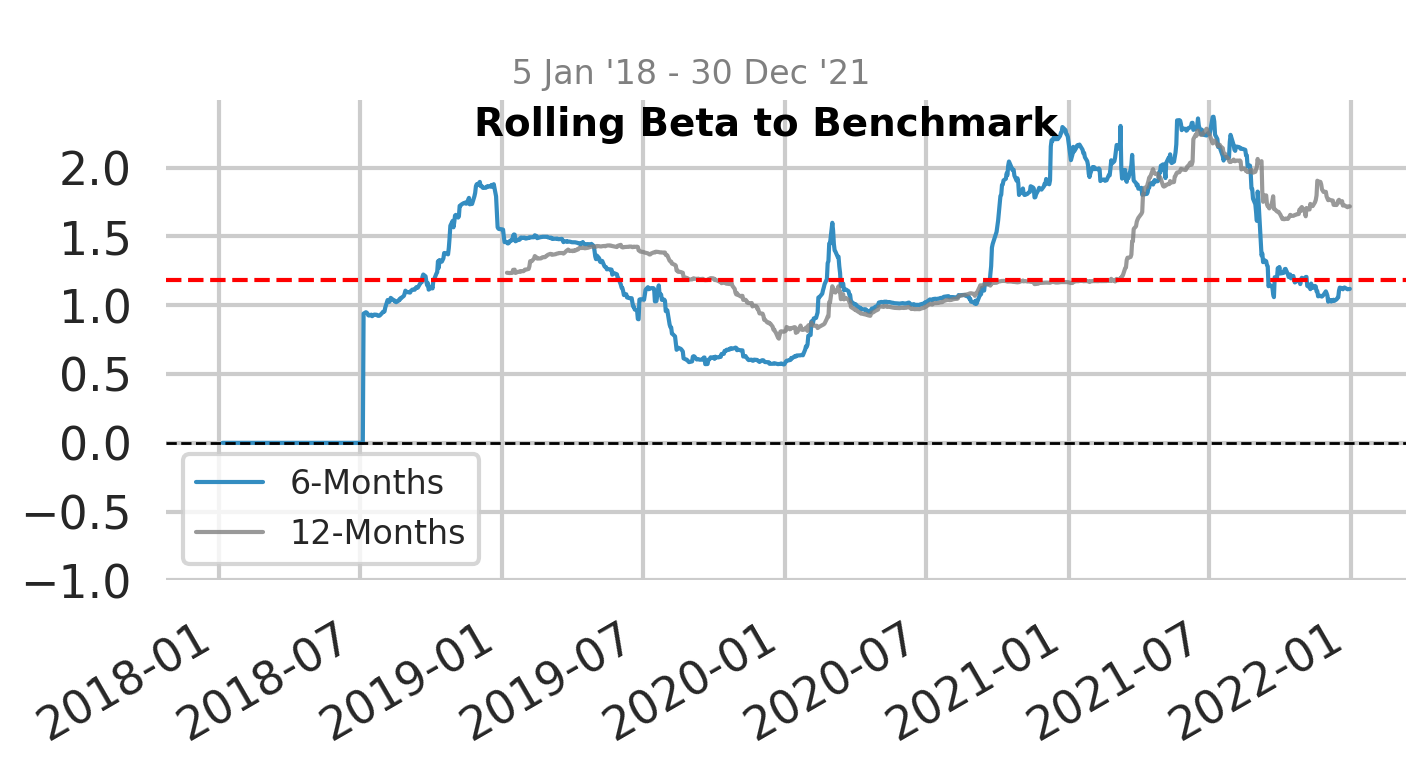

/usr/local/lib/python3.9/dist-packages/quantstats/_plotting/core.py:462: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


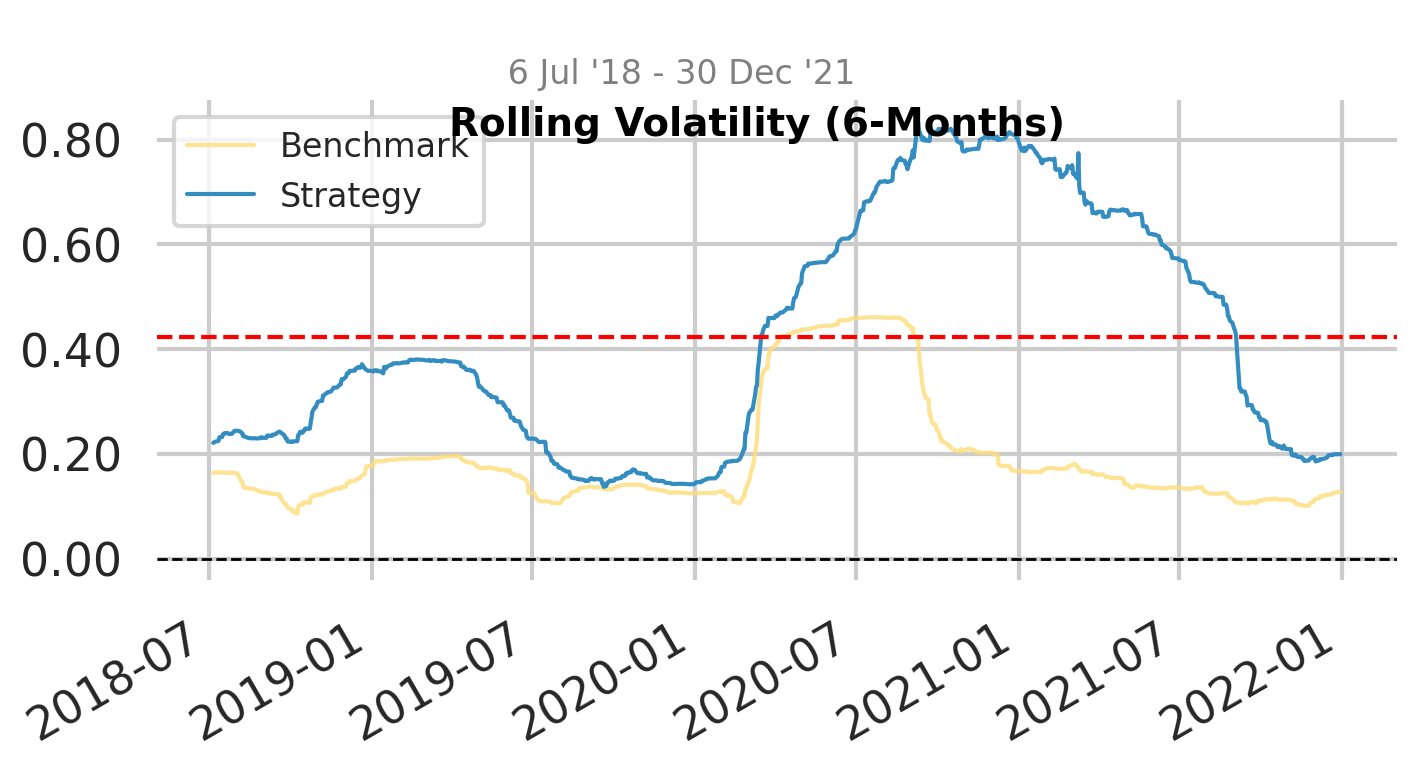

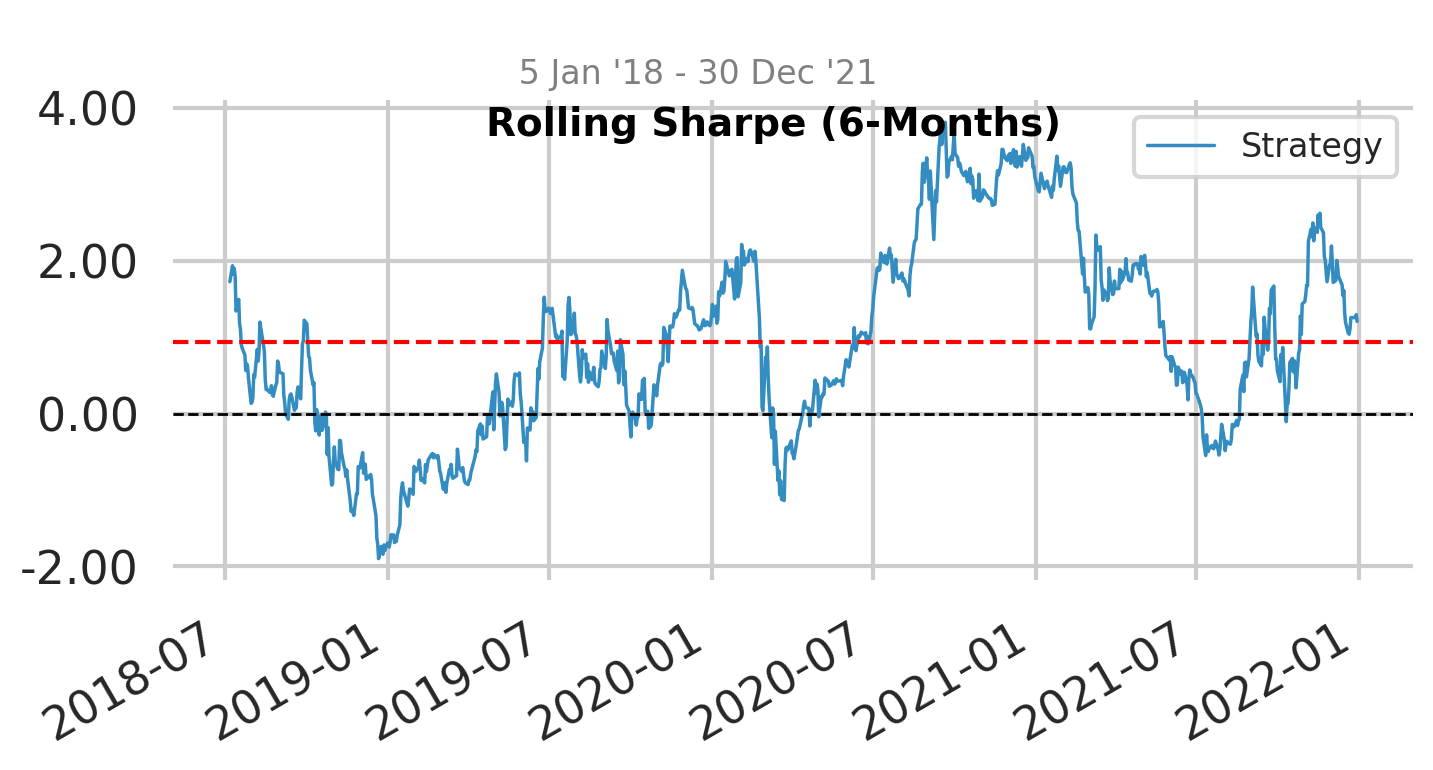

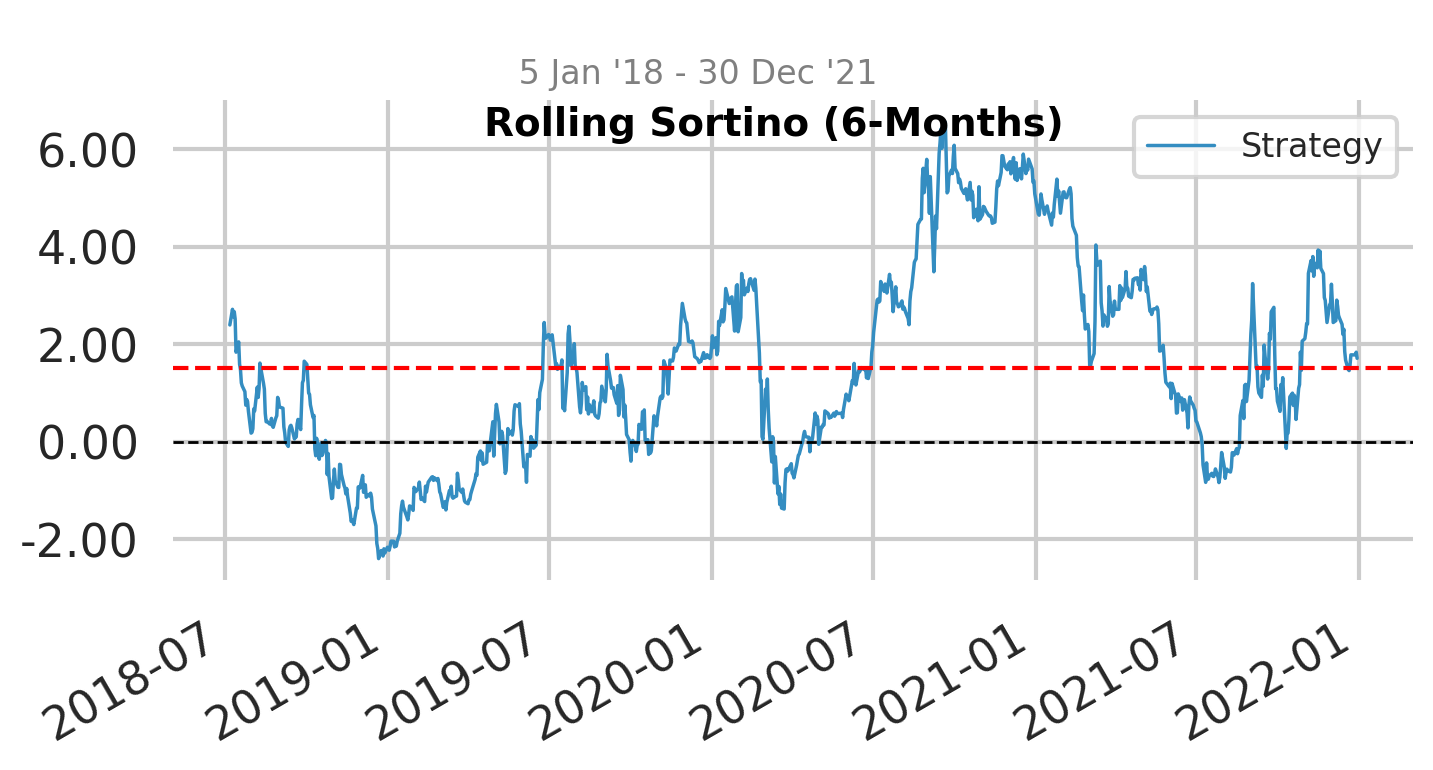

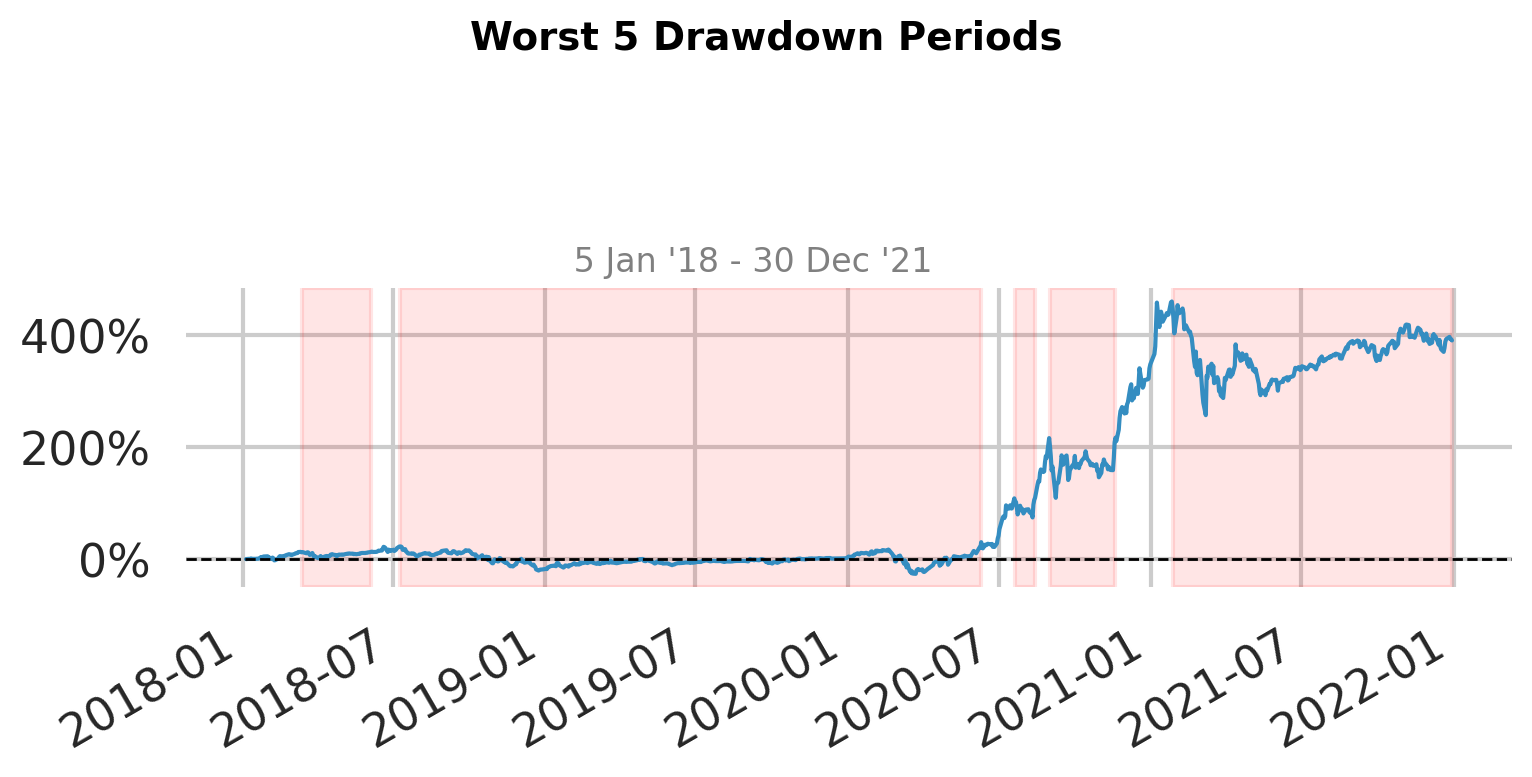

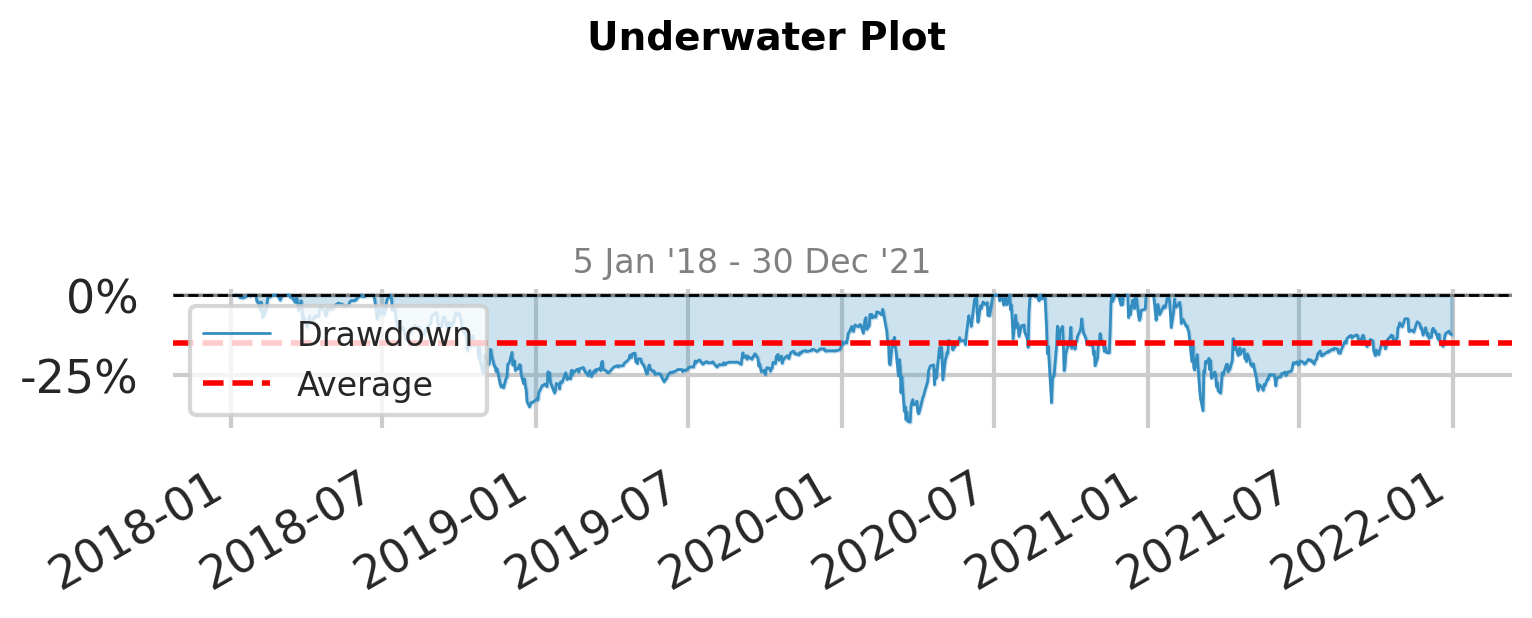

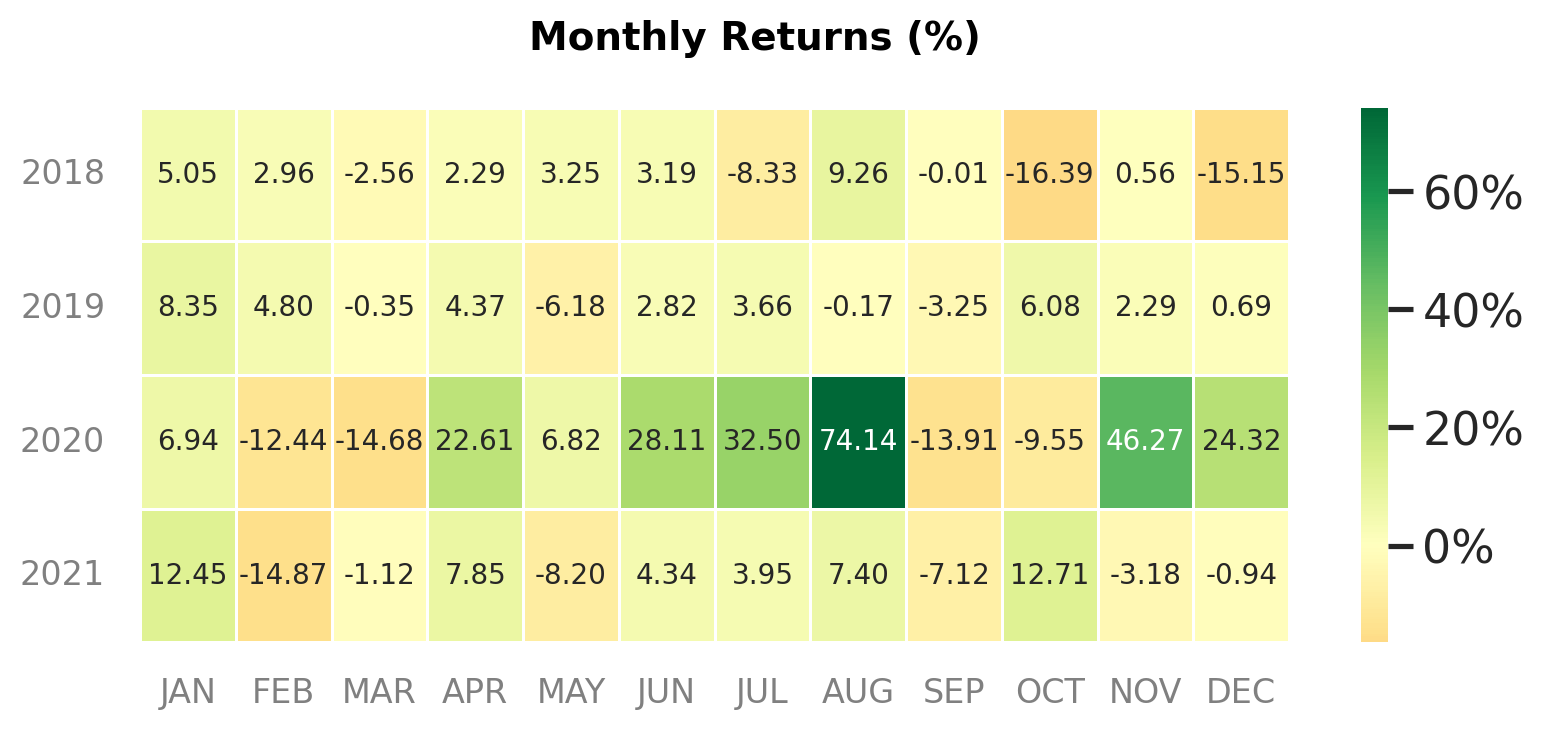

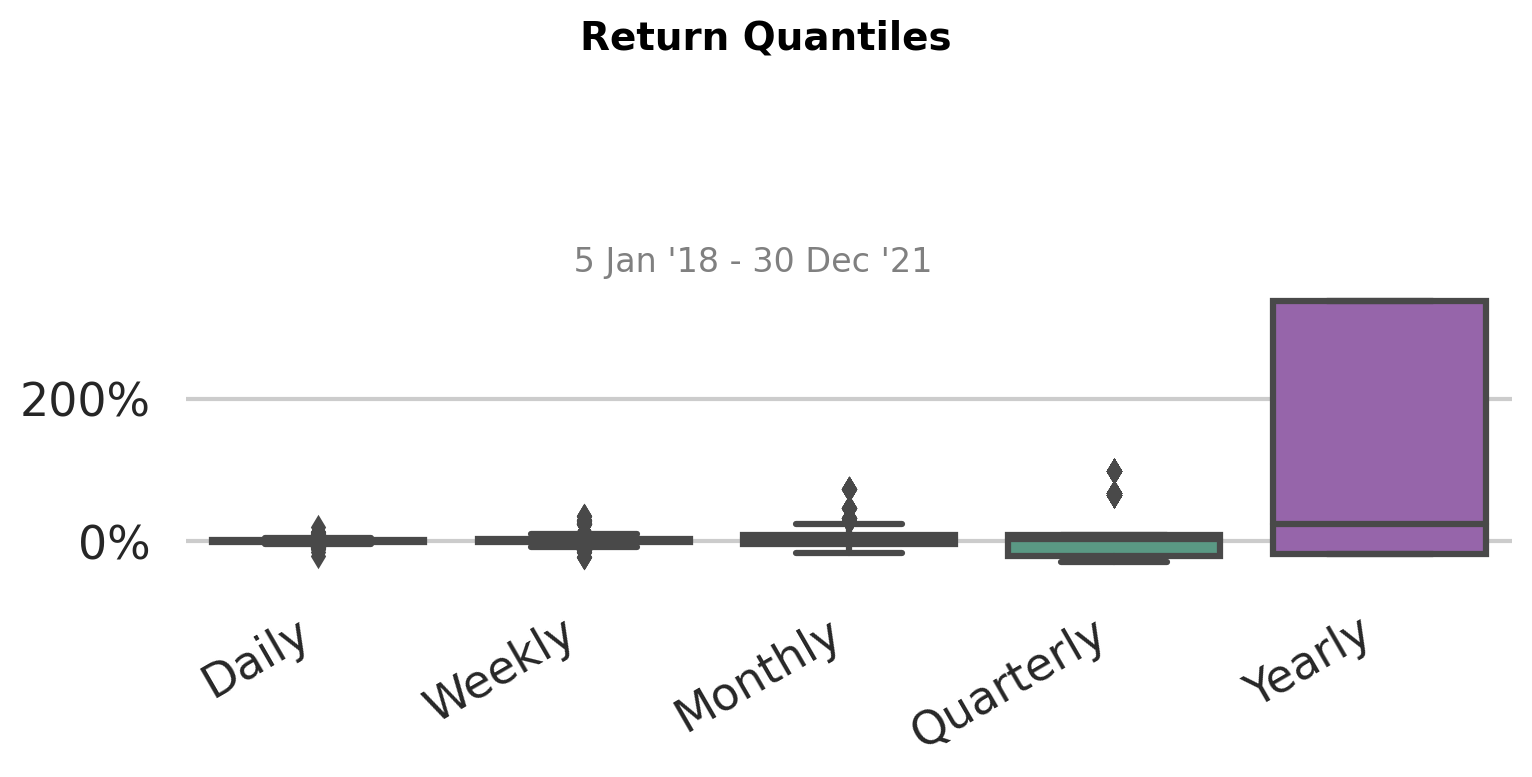

In [119]:
seleted_rows=returns_df.iloc[254:,:]
qs.reports.full(seleted_rows.squeeze(), benchmark=Benchmark.squeeze())